# Generic Data Source
## Processing and Figure Production Template

A template workflow for the analysis of federal funding information (namely grant records) for open-science-related endeavors.

### Overview

This notebook is designed to make use of the [code toolset]() provided with this repository and, in doing so, apply a customized data acquisition and processing workflow on your local system (which is presumed to not have the requisite data files--at least not the first time you run this notebook).  Once this data has been acquired and processed, some standard analyses are conducted and associated figures are generated.

#### A warning

Each of the workflow steps (e.g. acquisition, preprocessing, analysis, figure generation) takes a nontrivial amount of local storage space (e.g. 150 GB in the case of NIH data) and a nontrivial amount of processing time.  Be aware of this as you seek to enact this notebook.

### File paths and assumptions

We'll start by establishing a number of parameters and filepaths that will be used throughout this process.  **Be sure to inspect these to ensure that they are consistent with your local setup before proceeding**

In [1]:
import os
# we're going to assume that this notebook is being run from the /notebooks directory of the repository
# if this is not the case then you will need to adjust the path to the /inputData directory, which should be in the same directory as the /notebooks directory
inputDataDir='..' + os.sep + 'inputData' + os.sep

# relatedly, we will also need to make extensive use of code that has been developed for this project.
# this code is stored within the /src directory of the repository
codeDir='..' + os.sep + 'src' + os.sep
# we will need to add this code directory to the python path so that we can import the code
import sys
sys.path.append(codeDir)
import analyzeData
import getData
import processData
import figs

# within the inputDataDir, there could conceivably be a data directory for each of the potential data sources that this toolset was designed to work with
# these include: grants.gov, NIH, NSF, and USAspending
dataSources=['grantsGov','NIH','NSF','USAspending']
# we'll go ahead and select one of these using an integer index.  We'll default to the first one in the list, which is grants.gov
defaultDataIndex=0

# inside each of these data source directories, there should be a set of sub-directories corresponding to various phases of the workflow.  These are:
dataFolders=['raw','processed','analyzed','figures']
# the raw directory should contain the raw data files as downloaded from the data source
# the processed directory should contain the data files after they have been processed by the appropriate data processing functions for that data set
# the analyzed directory should contain the data derivitives of standard analysis functions
# the figures directory should contain the figures depicting the results of the various analyses

# additionally, one consequence of selecting a data source is that we need to go ahead and specify dataset-specfific fields or values that will come in to play lter
# data dictionary locations
# grants.gov : https://www.grants.gov/help/html/help/XMLExtract/XMLExtract.htm
# NIH : https://report.nih.gov/exporter-data-dictionary
# NSF : https://www.nsf.gov/awardsearch/resources/Award.xsd
# USAspending : https://www.usaspending.gov/data-dictionary

# Each data set, when split in to individual xml records (except for usaspending, which we don't do that for) needs to have a root element.
# Because most of the data sets didn't come as xml files, we arbitrarily set a root element that's the same for all of these, us ing grants.gov as the standard, which is 'rootTag'
rootTags=['rootTag','rootTag','rootTag','NotApplicable']

# for example, when looking for sub-organizations, each data-set has a different 
# given that the relevant field could be deeper or shallower for each set, we'll specify it as a list of lists, indicating the sequence of fields and subfields that need to be traversed to get to the relevant field
subOrgFields=[[['AgencyCode']],[['IC_Name']],[['Award'],['Organization'],['Directorate'],['LongName']],[['TBD']]]

# similarly there's the field for the "name" or identifier for the record
nameFields=[[['OpportunityID']],[['Activity']],[['Award'],['AwardID']],[['award_id_fain']]]

# also specify the field for the description
descriptionFields=[[['Description']],[['ABSTRACT_TEXT']],[['AbstractNarration']],[['description']]]

# for now though we must select a single data source.  For the purposes of this template, we wil default to the first exemplar in the dataSources list, which is grants.gov
defaultDataSource=dataSources[defaultDataIndex]

# additionally, one of the main goals / analyses of this project is to identify which funding records correspond to open-science endeavors
# The first-pass approach for this is to use a set of keywords as search targets within descriptions of the funding records.
# However several such keyword lists have been developed for this project.  These include:
keyWordOptions=['keywords.csv','OSterms_LeeChung2022.csv','GPT_OS-Terms.csv']
# as you may have surmised, each of these is a csv file containing a list of keywords.  The last column are the keywords themselves, while any preceeding colums correspond to higher-order categories that the keywords may be grouped into
# for now though we must select a single keyword list.  For the purposes of this template, we wil default to the second exemplar in the keyWordOptions list, which is OSterms_LeeChung2022.csv
defaultKeyWordList=keyWordOptions[1]

### Data acquisition

Each of the established data sources has an online repository which can be used to download the entirety of the corresponding data.  However, these are not standardized, and so it is necessary to use a custom created set of functions to download the corresponding data.  That is what we will do in the next section.

In order to ensure that we aren't wasting effort though, we'll be sure to check if there is already data in the 'raw' directory.  If so, we'll skip the downloading and proceed to the pre-processing phase.

**NOTE**: If it is necessary to download the data, this may take a particularly long time.  Additionally, depending on the data provider, it may be necessary to re-initiate the download process more than once to ensure a complete download of the dataset

In [2]:
from glob import glob
# first we set the path to the raw data directory for the selected data source
currentRawDataDir=os.path.join(inputDataDir,defaultDataSource,dataFolders[0])
# let's see if the directory exists and if so, if there are at least one compressed file (e.g. .zip, .gz, .tar, etc.) and one xml file (which would presumably be the uncompressed, and unprocessed data)
# if not, then we will need to download the data from the data source
rawDirContainsZIP=glob(currentRawDataDir + os.sep + '*.zip')
rawDirContainsGZ=glob(currentRawDataDir + os.sep + '*.gz')
rawDirContainsTAR=glob(currentRawDataDir + os.sep + '*.tar')
rawDirContainsCompressed=rawDirContainsZIP + rawDirContainsGZ + rawDirContainsTAR
rawDirContainsXML=glob(currentRawDataDir + os.sep + '*.xml')
# if we fail to find at least one compressed file or one xml file, then we will need to download the data from the data source
if (len(rawDirContainsCompressed)==0) or (len(rawDirContainsXML)==0):
    print('Search of raw data directory\n' + currentRawDataDir + '\n failed to find at least one compressed file and one xml file.  Downloading data from data source.')
    getData.getDataFromRemoteSource(currentRawDataDir,defaultDataSource)


## Data processing and cleaning
Assuming the data has been downloaded successfully, it now needs to be processed and, in some cases, cleaned and repaired.

As before we can check to see if this has already been done.  If not, this may take a while.

NOTE:  We'll also take this opportunity to check if dask is available on your system.  If it is we'll be able to parallelize some of our operations.

In [3]:
# check if dask is available
try:
    import dask
    daskAvailable=True
except:
    daskAvailable=False



# the resultant data should be stored in the grantsGov/processed directory
processedDataPath=os.path.join(inputDataDir,defaultDataSource,dataFolders[1])
# now process it with processDownloadedData
#  processDownloadedData(dataLocation,sourceOrg,saveDir,singleMulti='multi'):
# implement a quick little timer to see how long this takes
import time
start=time.time()
# do a quick check to see if the processed data directory already exists, and if there are any xml files in it
processedDataDirExists=os.path.isdir(processedDataPath)
# if it doesn't exist make it
if not processedDataDirExists:
    os.mkdir(processedDataPath)
# now check to see if there are any xml files in it
processedDataDirContainsXML=glob(processedDataPath + os.sep + '*.xml')
# if there are no xml files in the directory, then we need to process the data
if len(processedDataDirContainsXML)==0:
    print('No xml files found in processed data directory.  Processing data from raw data.')
    # if dask is available, then we can use it to speed up the processing
    if daskAvailable:
        # set up a dask client, and use all but 2 of the available cores
        from dask.distributed import Client
        import dask
        # check what the correct number of workers and threads should be given system resources
        # first get the number of cores available
        import multiprocessing
        nCores=multiprocessing.cpu_count()
        # now set the number of workers to be all but 2 of the available cores
        nWorkers=nCores-2
        # now set the number of threads per worker to be 1
        threadsPerWorker=1
        # now set up the client
        client = Client(n_workers=nWorkers, threads_per_worker=threadsPerWorker)
        # now process the data by running the processDownloadedData function with dask.delayed
        #  processDownloadedData(dataLocation,sourceOrg,saveDir,singleMulti='multi'):
        delayedProcessData=dask.delayed(processData.processDownloadedData)(currentRawDataDir,defaultDataSource,processedDataPath,singleMulti='multi')
        # now run the delayed process
        delayedProcessData.compute()
        # now close the client
        client.close()
    # if dask is not available, then we will have to process the data serially
    else:
        processData.processDownloadedData(currentRawDataDir,defaultDataSource,processedDataPath,singleMulti='multi')
else:
    print('xml files found in processed data directory.  Skipping processing.')
# now let's see how long that took
end=time.time()
print('Processing took ' + str(end-start) + ' seconds.')

xml files found in processed data directory.  Skipping processing.
Processing took 0.29171252250671387 seconds.


## Data quality assesment

Now that we have downloded and (ostensibly) cleaned the data, it would be nice to get a sense of the quality of the data.  In this case, this means determining, for each standard record field, what proportion are "empty".  This will give us a sense of how "complete" the data is.  This is a good initial check of the data quality, though it does not give us a sense of the accuracy or reasonability of the data.  Checks of this sort for _soundness_ require a detailed understanding of the data, the context from which it arises, and the entities to which the records correspond.  Ideally, checks of soundness have been implemented in the preprocessing stage and have been used to implement corrections.

Thus for this analysis, we'll print a table with the field names and number of empty entries.  To provide some context, the final row of the table will have the total number of record entries covered by the data set, which represents the maximal "emptyness" that could be acheived (i.e. if every record failed to have an entry for that field).

We'll also plot this as a bar chart as well--our first figure.

,fieldName,numEmpty
0,OpportunityID,0.0
1,OpportunityTitle,0.0
2,OpportunityNumber,0.0
3,OpportunityCategory,1.0
4,FundingInstrumentType,0.0
5,CategoryOfFundingActivity,0.0
6,CategoryExplanation,61843.0
7,CFDANumbers,0.0
8,EligibleApplicants,0.0
9,AdditionalInformationOnEligibility,22022.0


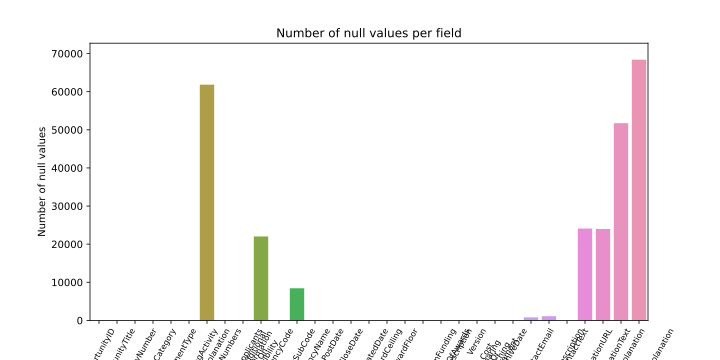

In [4]:
import pandas as pd
# implement path to the "analyzed" and "figures" directories
analyzedDataPath=os.path.join(inputDataDir,defaultDataSource,dataFolders[2])
figuresDataPath=os.path.join(inputDataDir,defaultDataSource,dataFolders[3])

# set the file paths to the files to be generated
dataCompletenessDFPath=os.path.join(analyzedDataPath,'dataCompletenessDF.csv')
dataCompletenessFigPath=os.path.join(figuresDataPath,'dataCompletenessFig.svg')
# now check to see if the files already exist
if not os.path.isfile(dataCompletenessDFPath) and os.path.isfile(dataCompletenessFigPath):
    # if they don't exist, then we need to generate them
    # lets gather up all of the xml files in the processed data directory into a list
    processedDataDirContainsXML=glob(processedDataPath + os.sep + '*.xml')

    # now we pass this to quantifyDataCompleteness
    dataCompletenessDF=analyzeData.quantifyDataCompleteness(processedDataDirContainsXML)
    # according to the documentation dataCompletenessDF should be: 
    #       A pandas dataframe with two columns:  the first column is the field name and the second column is the number of empty / null values for that field.
    #       The last row is the total number of records assessed.
    # for output, we'll present the table along side a bar plot of the number of empty / null values for each field
    # use figs.plotNullValue_barPlot(dataCompletenessDF,figSize=(10,5)) for this
    dataCompletenessFig=figs.plotNullValue_barPlot(dataCompletenessDF,figSize=(10,5))
    # set up the display for the side by side table and figure for jupyter notebooks
    # save both the dataCompletenessDF and the dataCompletenessFig
    dataCompletenessDF.to_csv(dataCompletenessDFPath)
    dataCompletenessFig.savefig(dataCompletenessFigPath)
else:
    # if they do exist, then we need to load them
    dataCompletenessDF=pd.read_csv(dataCompletenessDFPath,index_col=0)
    # still get the file paths
    processedDataDirContainsXML=glob(processedDataPath + os.sep + '*.xml') 

# in either case, we will want to display the table and figure
from IPython.display import display, SVG



display(dataCompletenessDF)
display(SVG(dataCompletenessFigPath))


### How do we find "Open Science Infrastructure"-related grants?

How can we tell which of these entries are related to-Open Science Infrastructure?  In eachd data set there is a field which provides information about the nature or purpose of the funded endeavor, typically as a sizeable block of text (e.g. `Description` in grants.gov or `abstract` in the NIH data set).  Ultimately, this field can provide a source of information that can be used in filtering or categorizing the entries.  If we can find a way to use the information contained within the description to determine whether or not the grant is related to this topic, we might be able to limit our consideration to this subset, and thereby be able to make insights about its characteristics.

Before we dive too deeply into using the `Description` it may be best for us to perform a sanity check and see how much information is contained within this field across the various grant entries. For this approach to be viable, a sufficient number of the grant descriptions will need to have a reasonable amount of text.

input type xmlFile detected


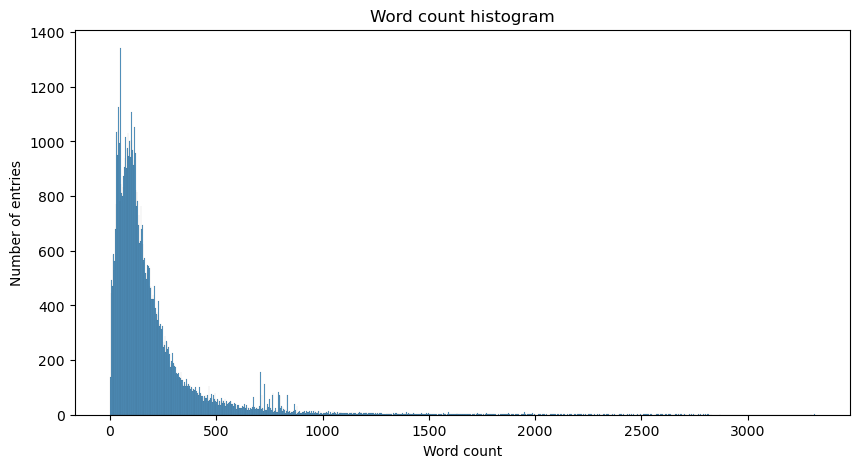

In [5]:
import os
# kind of a shot in the dark, but lets assume that the first field in the dataCompletenessDF is the name field
nameField=dataCompletenessDF.iloc[0,0]

#as for the target field, we'll see which of the following are in the dataCompletenessDF
descriptionCandidates=['Description','abstract','summary','descriptionText','abstractText','summaryText']
# now we'll loop through the descriptionCandidates and see if any of them are in the dataCompletenessDF, case insensitive
# get the field names from the dataCompletenessDF
fieldNames=dataCompletenessDF['fieldName'].values

targetField=''
for descriptionCandidate in descriptionCandidates:
    # check if the descriptionCandidate is in the fieldNames
    if descriptionCandidate in fieldNames:
        # if it is, then we'll set the targetField to be the descriptionCandidate
        targetField=descriptionCandidate
        # and we'll break out of the loop
        break
# if we didn't find a targetField, then we'll throw an error
if targetField=='':
    raise ValueError('No target field found in dataCompletenessDF.  Please specify a target field.')

# we'll use wordCountForField(inputStructs,targetField,nameField='infer',savePath='') to get the word count
# lets assume
rootTag='rootTag'

wordCountDF=analyzeData.wordCountForField(processedDataDirContainsXML,targetField=[rootTag,targetField],nameField=[rootTag,nameField],savePath=None)
# according to the documentation wordCountDF should be:
# A pandas dataframe with two columns: 'itemID' and 'wordCount'. The 'itemID' column contains the name of the input structure, and the 'wordCount'
#        column contains the word count of the target field for each input structure.
# now we'll plot the wordCountDF as a histogram
wordCountFig=figs.plotWordCount_histogram(wordCountDF,figSize=(10,5))

# save both the wordCountDF and the wordCountFig
wordCountDF.to_csv(os.path.join(analyzedDataPath,'wordCountDF.csv'))
wordCountFig.savefig(os.path.join(figuresDataPath,'wordCountFig.svg'))

### Searching for Open Science terms

Now that we have a sense of the information sources (i.e. descriptions) that we might be able to use to categorize or classify the entries, we can move towards actually applying our classification / categorization method.

Our goal is to find those entries that are specific to Open Science (and open science infrastructure).  How would we go about doing this?

We can make a first, naieve attempt at this by using a word-bank with words or phrases that we believe are likely to show up in a grant relevant to open science infrastructure (e.g. 'metadata', 'FAIR', 'data sharing', etc.). In this repository we have just such a word-bank already available (in keywords.txt), but users should feel free to update and/or augment it as they see fit.

To begin then, we'll do a quick search to see how many grants each of the word-bank terms comes up in.

In [6]:
import pandas as pd
#analyzedDataPath=os.path.join(inputDataDir,defaultDataSource,dataFolders[2])
#figuresDataPath=os.path.join(inputDataDir,defaultDataSource,dataFolders[3])
# create the path to the save product of the regex search
regexSearchSavePath=os.path.join(analyzedDataPath,'regexSearchResults.hd5')
# create the ptah to the csv containing the search terms, which should be in the main directory as of 07/12/2023
stringPhraseListPath=os.path.join('..',defaultKeyWordList)
# load the stringPhraseList
stringPhraseList=pd.read_csv(stringPhraseListPath)
# get the last column of the stringPhraseList and use it as the keywordList
keywordList=stringPhraseList.iloc[:,-1].values
# check if the regexSearchSavePath file exists, and if so, don't rerun the regex search
if os.path.exists(regexSearchSavePath):
    print('regexSearchSavePath file already exists.  Skipping regex search.')
else:
    # run the regex search
    # regexSearchAndSave(processedDataPath,keywordList,targetField,nameField='infer',rootTag='root
    analyzeData.regexSearchAndSave(processedDataPath,keywordList,[rootTag,targetField],savePath=regexSearchSavePath)
# load up the results
import h5py
regexSearchResults=h5py.File(regexSearchSavePath,'r')
# remember:
# efficientDict['rowDescription']='Searched Keywords'
# efficientDict['colDescription']='Award Number'
# dataKeys=['dataMatrix','rowName','colName']
# attributeKeys=['rowDescription','colDescription']
# so we'll get the dataMatrix from the regexSearchResults as a numpy array
regexSearchResultsDataMatrix=regexSearchResults['dataMatrix'][:]
# and the rowName, but remember they come in as bytes, so we'll need to decode them
regexSearchResultsRowNames=[rowName.decode('utf-8') for rowName in regexSearchResults['rowName'][:]]
# we don't need the colName as these are the award numbers and we don't need these
# create a save path for the keywordCounts DF
keywordCountsSavePath=os.path.join(analyzedDataPath,'keywordCounts.csv')
# create the keywordCountsDF
# because each row is a keyword, you can just sum across the columns to get the counts for that keyword
# the keywords themselves come from the regexSearchResultsRowNames
# make sure the DF has column names of 'itemID' and 'count'
keywordCountsDF= pd.DataFrame(data={'itemID':regexSearchResultsRowNames,'count':regexSearchResultsDataMatrix.sum(axis=1)})
# now we'll plot the keywordCountsDF as a bar plot in seaborn
# keywordCount_barPlot(keywordCountDF,figSize=(10,5),fig=None,ax=None,figSavePath=None)
# create the path to save the figure
keywordCountsFigSavePath=os.path.join(figuresDataPath,'keywordCountsFig.svg')
keywordCountsFig=figs.keywordCount_barPlot(keywordCountsDF,figSize=(10,5),fig=None,ax=None,figSavePath=keywordCountsFigSavePath)
# display the keywordCountsDF and the keywordCountsFig
display(keywordCountsDF)
display(keywordCountsFig)

Searching for the string phrase: replication crisis
Searching for the string phrase: methodology
Searching for the string phrase: preregistration
Searching for the string phrase: replication
Searching for the string phrase: registered reports
Searching for the string phrase: preprints
Searching for the string phrase: social sciences
Searching for the string phrase: reproducibility


### What counts and what doesn't

Now that we have a broad overview of the frequency at which the relevant terms are occuring in the data set, perhaps we should take a step back and consider what we are visualizing in the above figure.

Namely, for each of these columns, the number corresponds to the number of records which have the relevant term.  Does this mean that the record is related to open science or open science infrastructure?  Not at all.  It could be that the entry in question uses the term in passing, or in a context that is distinct from open science / infrastructure. Presumably though, a "legitimately" open science entry will likely mention _several_ open science related terms (assuming our keyword list is comprehensive / representative enough).  To that end, we may wish to get a sense of what the distribution of keyword hits is across our entries.

,count,numObserved
0,1.0,35892
1,2.0,23833
2,3.0,8517
3,4.0,3164
4,5.0,809
5,6.0,326
6,7.0,100
7,8.0,35
8,10.0,16
9,9.0,15


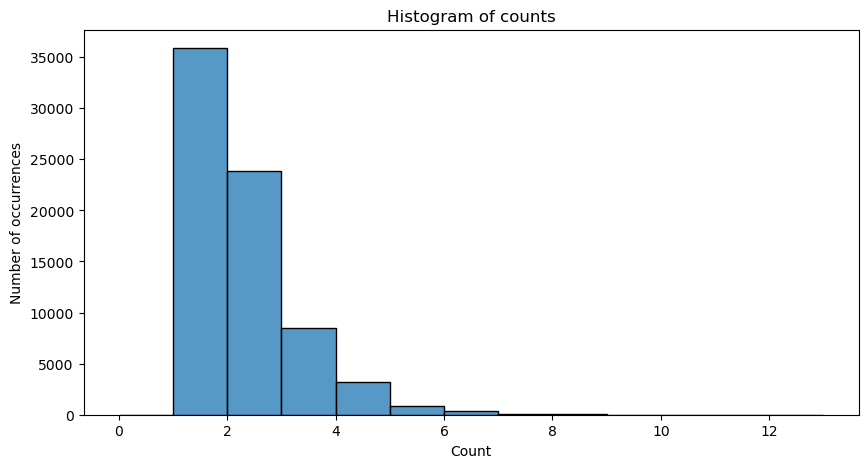

In [ ]:
#we'll use the plotting function matrix_histogramCounts(inputMatrix,keepAxis='columns',dropZero=True,binSize=1,figSize=(10,5),fig=None,ax=None,figSavePath=None) for this
# create the path to save the figure
keywordCountsMatrixFigSavePath=os.path.join(figuresDataPath,'keywordCountsMatrixFig.svg')
keywordCountsMatrixFig,figAxis,histDF=figs.matrix_histogramCounts(regexSearchResultsDataMatrix,keepAxis='columns',dropZero=True,binSize=1,figSize=(10,5),fig=None,ax=None,figSavePath=keywordCountsMatrixFigSavePath)
# display the histDF as well
display(histDF)



### A closer look at the select few

Given the distribution of values in the previous plot, it seems like 3 might serve as a reasonable threshold, such that we are only looking at records with three or more key terms in them.  

#### ... And a further sanity check

As a further sanity check, we can also present an interactive table (assuming this is being viewed / interacted with as a jupyter notebook and not a static report)  We'll plot these in *reverse* order such that the records with the _highest_ number of hits are presented first.

In [ ]:
import numpy as np
import xmltodict
import h5py
# we'll begin with the creation of the thresheld dataset
thresholdValue=3
# now create a path to the hdf5 file that will contain the thresholded dataset
thresholdedDataSavePath=os.path.join(analyzedDataPath,'thresholdedData.hd5')
# check if the thresholdedDataSavePath file exists. If it doesn't exist, then we'll apply the threshold
# if it does exist, then we'll load it up
if not os.path.exists(thresholdedDataSavePath): 
    # looking back at regexSearchResultsDataMatrix, we'll find the indexes of the columns (i.e. the award numbers) that have at least thresholdValue or more keyword hits
    # we'll use numpy's where function for this

    # get the indexes of the columns that have at least thresholdValue or more keyword hits when regexSearchResultsDataMatrix is summed across the rows
    thresholdSurvivorIndexes=np.where(regexSearchResultsDataMatrix.sum(axis=0)>=thresholdValue)[0]
    # now we'll use these indexes to get the subset of columns from regexSearchResultsDataMatrix
    thresholdedData=regexSearchResultsDataMatrix[:,thresholdSurvivorIndexes]
    # but also remember that we need to get the subset of colNames
    thresholdedColNames=[regexSearchResults['colName'][i] for i in thresholdSurvivorIndexes]
    # now we'll save the thresholdedData, thresholdedColNames, and original rowNames to the thresholdedDataSavePath
    # we'll use h5py for this
    # first create the file
    thresholdedDataFile=h5py.File(thresholdedDataSavePath,'w')
    # now create the datasets
    thresholdedDataFile.create_dataset('dataMatrix',data=thresholdedData)
    thresholdedDataFile.create_dataset('colName',data=thresholdedColNames)
    thresholdedDataFile.create_dataset('rowName',data=regexSearchResults['rowName'][:])
    # now also add an attribute to the file indicating the thresholdValue
    thresholdedDataFile.attrs['thresholdValue']=thresholdValue
    # now close the file
    thresholdedDataFile.close()
# in either case, we will want to load the thresholdedData
thresholdedDataHD5File=h5py.File(thresholdedDataSavePath,'r')
# now get the dataMatrix, colName, and rowName
thresholdedDataMatrix=thresholdedDataHD5File['dataMatrix'][:]
thresholdedColNames=[colName.decode('utf-8') for colName in thresholdedDataHD5File['colName'][:]]
thresholdedRowNames=[rowName.decode('utf-8') for rowName in thresholdedDataHD5File['rowName'][:]]
# and the thresholdValue
thresholdFileValue=thresholdedDataHD5File.attrs['thresholdValue']

# now we'll present a table of the post-threshold entries, wherein the number of keyword hits is presented alongside the award number, the description, and sub-organization
# but actually in this order: [award number, sub-organization, number of keyword hits, description]
# this may be a bit ugly / slow, but here we go

# first we'll get the post-threshold award numbers, which is thresholdedColNames
postThresholdAwardNumbers=thresholdedColNames
# now we'll get the count of keyword hits for each award number, which is the sum of the rows of thresholdedDataMatrix
postThresholdKeywordCounts=thresholdedDataMatrix.sum(axis=0)
# lets go ahead and create a pandas dataframe, which we will subsequently iterate across
postThresholdInspectionDF=pd.DataFrame(data={'awardNumber':postThresholdAwardNumbers,'keywordCount':postThresholdKeywordCounts})
# now we'll iterate across the rows of postThresholdInspectionDF, load up the corresponding xml file, and extract the description and sub-organization
# NOTE: itterows is allegedly slow, but we don't have the bandwidth to overengineer this right now
for iRows in postThresholdInspectionDF.iterrows():
    # get the awardNumber
    awardNumber=iRows[1]['awardNumber']
    # index back in to the regexSearchResultsDataMatrix to get the row indexes for the non-zero rows
    nonZeroRowIndexes=np.where(regexSearchResultsDataMatrix[:,thresholdedColNames.index(awardNumber)]>0)[0]
    # use this to create a list of the keywords that were hit
    keywordsHit=[thresholdedRowNames[i] for i in nonZeroRowIndexes]
    # add this to the postThresholdInspectionDF
    postThresholdInspectionDF.loc[iRows[0],'keywordsFound']=keywordsHit
    # use that to load up the corresponding xml file
    # NOTE: WE HAVE REWRITTEN the naming convention used for the data structure, currently, the colName includes the file extension for some reason, but moving forward it will not.
    awardNumberXMLPath=os.path.join(processedDataPath,awardNumber+'.xml')
    #awardNumberXMLPath=os.path.join(processedDataPath,awardNumber)
    # load it
    currXMLdictionary=xmltodict.parse(open(awardNumberXMLPath).read())
    # create the field tree sequence for the award description and sub-organization
    # NOTE: not elegant, but it works
    awardDescriptionFieldSequence=[]
    awardDescriptionFieldSequence.extend([rootTags[defaultDataIndex]])
    [awardDescriptionFieldSequence.extend(x) for x in descriptionFields[defaultDataIndex]]
    #awardDescriptionFieldSequence.extend(descriptionFields[defaultDataIndex])
    awardSubOrgFieldSequence=[]
    awardSubOrgFieldSequence.extend([rootTags[defaultDataIndex]])
    [awardSubOrgFieldSequence.extend(x) for x in subOrgFields[defaultDataIndex]]
    #awardSubOrgFieldSequence.extend(subOrgFields[defaultDataIndex])
    # print both of them for debugging
    # now extract the description and sub-organization
    awardDescription=analyzeData.extractValueFromDictField(currXMLdictionary,awardDescriptionFieldSequence)
    awardSubOrg=analyzeData.extractValueFromDictField(currXMLdictionary,awardSubOrgFieldSequence)
    # now add these to the postThresholdInspectionDF
    postThresholdInspectionDF.loc[iRows[0],'description']=awardDescription
    postThresholdInspectionDF.loc[iRows[0],'subOrg']=awardSubOrg

# save it down
postThresholdInspectionDF.to_csv(os.path.join(analyzedDataPath,'postThresholdInspectionDF.csv'))
# now display postThresholdInspectionDF in an interactive table
from IPython.display import display
display(postThresholdInspectionDF)


,awardNumber,keywordCount,description,subOrg
0,269408.xml,3.0,The purpose of this Funding Opportunity Announ...,HHS
1,307227.xml,3.0,The California (CA) Bureau of Land Management ...,DOI
2,45411.xml,4.0,This funding opportunity announcement (FOA) is...,HHS
3,298460.xml,3.0,The purpose of this funding opportunity announ...,HHS
4,344981.xml,4.0,U.S. Embassy Tokyo&#8217;s Public Affairs Sect...,DOS
...,...,...,...,...
12987,139113.xml,3.0,The U.S. Department of Energy&apos;s Office of...,PAMS
12988,320460.xml,10.0,The CRRP seeks to enhance medical capabilities...,DOD
12989,124174.xml,3.0,This Funding Opportunity Announcement (FOA) en...,HHS
12990,334179.xml,3.0,The intent of the FY21 CPMRP IIRA is to suppor...,DOD


### Considering higher order patterns

Now that we have looked at the records in an individual fashion, we can begin trying to enrich this consideration by looking at the _context_ in which these terms are being found.  for example, some questions we can ask are:

- 1. What other terms is this term found with?
- 2. What sub-organizations are associated with uses of the term.

In the next section we'll make an effort to quantify and visualize these features.

In [ ]:
"""
Now that we have filtered the data to only be considering relevant entries, we can look at the contexts in which the terms are co-occuring, either with respect to other terms or with respect to organizational sub-divisions.

in order to assess the term-term co-occurance we will use:
coOccurrenceMatrix(occurenceMatrix,rowsOrColumns='rows',savePath='')
however, assessing the term-agency co-occurance will be a bit more complicated, and we will need to extract the grantID-agency data using 
fieldExtractAndSave(inputStructs,targetField,nameField='infer',savePath='')

The fist step for either of these is to create a path to the saved product, and determine if it already exists
"""
# create the path to the save product of the coOccurrenceMatrix
# note that we're saving it as a csv, because it should be pretty small given that we have a relatively small number of terms.
coOccurrenceMatrixSavePath=os.path.join(analyzedDataPath,'coOccurrenceMatrix.csv')
# create the path to the save product of the fieldExtractAndSave, remember that what we will be searching for in this case is agency
agencyExtractSavePath=os.path.join(analyzedDataPath,'agencyExtract.hd5')
# finally, create a save path for the agency-term co-occurrence matrix
agencyTermCoOccurrenceMatrixSavePath=os.path.join(analyzedDataPath,'agencyTermCoOccurrenceMatrix.csv')

# we'll start with the easy case: co-occurrence of terms
# check if the coOccurrenceMatrixSavePath file exists. If it doesn't exist, then we'll run analyzeData.coOccurrenceMatrix.
if not os.path.exists(coOccurrenceMatrixSavePath):
    # generate the coOccurrenceMatrix, using regexSearchResultsDataMatrix from the previously performed / loaded regex search
    # as before, the assumption is that terms are the rows, and the award numbers are the columns
    # NOTE: THIS MEANS `rowsOrColumns` SHOULD BE SET TO 'columns'
    analyzeData.coOccurrenceMatrix(thresholdedDataMatrix,rowsOrColumns='columns',savePath=coOccurrenceMatrixSavePath)
# in either case, load up the coOccurrenceMatrix
coOccurrenceMatrix=pd.read_csv(coOccurrenceMatrixSavePath,index_col=0,header='infer')
# because we know this is the term co-occurrence matrix, we can go ahead and set the diagonal to nan
import numpy as np
np.fill_diagonal(coOccurrenceMatrix.values,np.nan)
# we'll just hold on to that for now, and move on to the more complicated case: term-agency co-occurrence

# check if the agencyExtractSavePath file exists. If it doesn't exist, then we'll run analyzeData.fieldExtractAndSave.
currSubOrgField=awardSubOrgFieldSequence
# generate the nameFieldSequence
nameFieldSequence=[]
nameFieldSequence.extend([rootTags[defaultDataIndex]])
[nameFieldSequence.extend(x) for x in nameFields[defaultDataIndex]]
currNameFieldFull=nameFieldSequence
if not os.path.exists(agencyExtractSavePath):
    # generate the agencyExtract data, using fieldExtractAndSave(inputStructs,targetField,nameField,savePath)
    analyzeData.fieldExtractAndSave(processedDataDirContainsXML,currSubOrgField,currNameFieldFull,agencyExtractSavePath)
# in either case, load up the agencyExtract.  Given that it is a single column, it's always saved as a csv
agencyExtract=pd.read_csv(agencyExtractSavePath,header='infer')
# it should have two columns, the first is the award number ('itemID'), and the second is the agency ('fieldValue')

# now that we have that, check to see if the agencyTermCoOccurrenceMatrixSavePath file exists. If it doesn't exist, then we'll run analyzeData.coOccurrenceMatrix.
if not os.path.exists(agencyTermCoOccurrenceMatrixSavePath):
    # for sumMergeMatrix_byCategories, we'll need to create a `matrix` variable, which is equivalent to our `regexSearchResultsDataMatrix` *except that*
    # it's a pandas dataframe, with the rows and columns taken from the `rowName` and `colName` attributes of the `regexSearchResults` hdf5 file
    # [x.decode('utf-8') for x in grantIDs]
    pandasMatrix=pd.DataFrame(data=regexSearchResultsDataMatrix,index=[x.decode('utf-8') for x in regexSearchResults['rowName'][:]],columns=[x.decode('utf-8') for x in regexSearchResults['colName'][:]])

    analyzeData.sumMergeMatrix_byCategories(pandasMatrix,agencyExtract,targetAxis='columns',savePath=agencyTermCoOccurrenceMatrixSavePath)

# in either case, load up the agencyTermCoOccurrenceMatrix in the fashion appropriate for the file extension
if agencyTermCoOccurrenceMatrixSavePath.endswith('.csv'):
    agencyTermCoOccurrenceMatrix=pd.read_csv(agencyTermCoOccurrenceMatrixSavePath,index_col=0,header='infer')
elif agencyTermCoOccurrenceMatrixSavePath.endswith('.hd5'):
    agencyTermCoOccurrenceMatrixLoad=pd.read_hdf(agencyTermCoOccurrenceMatrixSavePath)
    # let's quickly reshape the hd5 output to a pandas dataframe; the row and column names will come from the 'rowName' and 'colName' datasets, whereas the main dataset will come out as 'dataMatrix'
    agencyTermCoOccurrenceMatrix=pd.DataFrame(data=agencyTermCoOccurrenceMatrixLoad['dataMatrix'][:],index=[x.decode('utf-8') for x in agencyTermCoOccurrenceMatrixLoad['rowName'][:]],columns=[x.decode('utf-8') for x in agencyTermCoOccurrenceMatrixLoad['colName'][:]])
    # keep in mind the row and column names are in there as independent datasets, so you'll need to get those out too if needed. 

# create savepaths for both figures
termTermCoOccurrenceMatrixFigSavePath=os.path.join(figuresDataPath,'termTermCoOccurrenceMatrixFig.svg')
agencyTermCoOccurrenceMatrixFigSavePath=os.path.join(figuresDataPath,'agencyTermCoOccurrenceMatrixFig.svg')
# now we use plot functions to take care of the rest, theoretically we could try and do these as subplots, but that likely won't work well considering the colorbars
# first we'll do the term-term co-occurrence
# plotCoOccurrenceMatrix(coOccurrenceMatrix,figSize=(10,10),rowTitle='Keywords',colTitle='Keywords',fig=None,ax=None,figSavePath=termTermCoOccurrenceMatrixFigSavePath)
termTermCoOccurrenceMatrixFig=figs.plotCoOccurrenceMatrix(coOccurrenceMatrix,figSize=(10,10),rowTitle='Keywords',colTitle='Keywords',fig=None,ax=None,figSavePath=termTermCoOccurrenceMatrixFigSavePath)
# now we'll do the agency-term co-occurrence
# plotCoOccurrenceMatrix(agencyTermCoOccurrenceMatrix,figSize=(10,10),rowTitle='Keywords',colTitle='Agency',fig=None,ax=None,figSavePath=agencyTermCoOccurrenceMatrixFigSavePath)
agencyTermCoOccurrenceMatrixFig=figs.plotCoOccurrenceMatrix(agencyTermCoOccurrenceMatrix,figSize=(10,10),rowTitle='Keywords',colTitle='Agency',fig=None,ax=None,figSavePath=agencyTermCoOccurrenceMatrixFigSavePath)

KeyError: "None of [Int64Index([344823, 346917, 335685, 342147, 344380, 343154, 343156, 343155,\n            343170, 333777, 336384, 335686, 333754, 346923, 343163, 335612],\n           dtype='int64')] are in the [columns]"

In [ ]:
keywordCountsDF

,itemID,count
0,replication crisis,0.0
1,methodology,1510.0
2,preregistration,0.0
3,replication,241.0
4,registered reports,1.0
5,preprints,4.0
6,social sciences,550.0
7,reproducibility,127.0
8,transparency,452.0
9,replicability,9.0


In [ ]:
print(type(regexSearchResultsDataMatrix))

<class 'numpy.ndarray'>


In [ ]:
# now we want to plot the results using seaborn
# start by loading the hdf5 file with the results
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
# recall this is how we set the path previously
hd5Path=os.path.join(localDataDir,'grantsGov','processed',currenthSearchList + '_results.h5')
# load the file
saveDictionary=h5py.File(hd5Path,'r')

# also load the agencies
#hd5Path=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.h5')\
# load the file
#agencyDictionary=h5py.File(hd5Path,'r')
# NOTE actually we changed this, because a 2D matrix is super inefficient when each row / grant can only have a single agency
# as such we are now using a csv file
agencyPath=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.csv')
agencyDictionary=pd.read_csv(agencyPath)


# we'll produce a bar plot where the x axis is the number of term matches in a given grant, and the y axis is the number of grants with that number of term matches
# additionally, we'll color subsections of the bars by the agency
# we'll start by getting the list of agencies
# this is a list of strings
agencyList=np.unique(agencyDictionary['fieldValue'].tolist())
# next create a mapping for the colors
# we'll use the seaborn color palette
# first get the number of agencies
numAgencies=len(agencyList)
# then get the color palette
colorPalette=sns.color_palette("hls", numAgencies)

# next we need to ensure that the data structure can be plotted as a stacked bar plot
# we'll start by counting the number of term matches for each grant
# this is a vector of integers
termMatchCounts=np.count_nonzero(saveDictionary['dataMatrix'],axis=0)
# lets create a pandas dataframe to hold the data we will plot
# the rows will correspond to the number of term matches, while the columns will correspond to the agencies
# we'll start by getting the maximum number of term matches
maxTermMatches=np.max(termMatchCounts)
# next we'll create a pandas dataframe with, where the column names come from agencyList
# and the row names come from the number of term matches
# we'll initialize the dataframe with zeros
plotData=pd.DataFrame(np.zeros((maxTermMatches,numAgencies)),columns=agencyList)
# next we also need to make sure that the entries in agencyDictionary['itemID']
# are in the same order as the the columns / grants in saveDictionary['dataMatrix']
# the specific grantIDs for saveDictionary are found in saveDictionary['colName']
# we'll start by getting the grantIDs from saveDictionary
# hopefully these are strings and not bytes
grantIDs=saveDictionary['colName'][:]
# if the first entry is a byte, we'll convert all of them to strings
if type(grantIDs[0])==bytes:
    grantIDs=[x.decode('utf-8') for x in grantIDs]
    
# next we'll get the grantIDs from agencyDictionary
agencyGrantIDs=agencyDictionary['itemID'].tolist()
# we'll do a quick check to make sure that the two lists are the same
if not grantIDs==agencyGrantIDs:
    # if they are not the same, we'll need to reorder the rows of agencyDictionary
    # we'll start by getting the indices that would sort grantIDs
    sortIndices=np.argsort(grantIDs)
    # then we'll get the indices that would sort agencyGrantIDs
    agencySortIndices=np.argsort(agencyGrantIDs)
    # then we'll chain these to get the indices that would sort agencyDictionary to the same order as saveDictionary
    correctSortIndices=np.argsort(agencySortIndices[sortIndices])
    # then we'll use these indices to reorder agencyDictionary
    agencyDictionary=agencyDictionary[correctSortIndices,:]
# NOTE: Maybe none of this is necessary


# next we'll iterate over the agencies 
for i in range(numAgencies):
    # set the current agency
    currentAgency=agencyList[i]
    # get the indices of in the values in agencyDictionary['fieldValue'] that match currentAgency
    currentIndices=np.where(agencyDictionary['fieldValue'][0,:]==currentAgency)[0]
    # use these indicies on agencyDictionary['itemID'] to get the grantIDs
    currentGrantIDs=agencyDictionary['itemID'][0,currentIndices]
    # then use these grantIDs to get the indices of the grants in saveDictionary['colName']
    currentAgencyGrantIndices=[grantIDs.index(x) for x in currentGrantIDs]
    # then use these indices to get the number of term matches for the grants
    currentTermMatchCounts=termMatchCounts[currentAgencyGrantIndices]
    # then iterate over the range between 0 and maxTermMatches and fill in the associated rows of plotData with the counts
    for j in range(0,maxTermMatches+1):
        # check to see if j is even in currentTermMatchCounts
        if j in currentTermMatchCounts:
            # if it is, then get the number of times it occurs
            currentCount=np.count_nonzero(currentTermMatchCounts==j)
            # then set the corresponding entry in plotData to this count
            plotData[currentAgency][j]=currentCount

# now we can plot the data

# set the seaborn style
sns.set(style="whitegrid")
# set the figure size
plt.figure(figsize=(10, 6))
# set the x axis label
plt.xlabel('Number of term matches')
# set the y axis label
plt.ylabel('Number of grants')
# set the title
plt.title('Number of term matches per grant')

# we'll use an iterative approach to plot the data
# this will require a bit of trickery, but we shold be fine
# we'll iterate over the agencies
# but first we need to create a vector to store the total count of grants for each count number, it will start as a vector of zeros
totalCount=np.zeros(maxTermMatches+1)
# then we'll iterate over the agencies
for i in range(numAgencies):
    # set the current agency
    currentAgency=agencyList[i]
    # set the current color
    currentColor=colorPalette[i]
    # create a temporary dataframe with the current agency, where the are two columns, 
    # the first simply has the number of term matches, and the second has the number of grants with that number of term matches
    tempData=pd.DataFrame({'termMatches':plotData[currentAgency].index,'grantCount':plotData[currentAgency].values})
    # BEFORE WE PLOT THOUGH
    # we need to recompute and reset the grant counts, to account for the fact that we are plotting a stacked bar plot
    # we'll start by getting the grant counts
    currentGrantCounts=tempData['grantCount'].values
    # then we'll add them to the totalCount
    totalCount=totalCount+currentGrantCounts
    # then we'll set the grant counts to the totalCount
    tempData['grantCount']=totalCount
    # then we'll plot the data
    plt.bar(tempData['termMatches'],tempData['grantCount'],color=currentColor,label=currentAgency)

# then we'll add the legend
plt.legend(loc='upper right')
# then we'll save the figure
plt.savefig(os.path.join(localDataDir,'grantsGov','figures','termMatchCounts.png'))





NameError: name 'localDataDir' is not defined

In [ ]:
saveDictionary['colName'][:]

array([b'54801.xml', b'269408.xml', b'313139.xml', ..., b'282128.xml',
       b'266576.xml', b'323977.xml'], dtype=object)

In [ ]:
np.unique(countsList)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

#### With a simple keyword search

We can make a first, naieve attempt at this by using a word-bank with words or phrases that we believe are likely to show up in a grant relevant to open science infrastructure (e.g. 'metadata', 'FAIR', 'data sharing', etc.).  In this repository we have just such a word-bank already available (in `keywords.txt`), but users should feel free to update and/or augment it as they see fit.

To begin then, we'll do a quick search to see how many grants each of the word-bank terms comes up in.

In [ ]:
import json
import seaborn as sns
import itertools
import pandas as pd
import matplotlib.pyplot as plt


# open the keywords file
with open('../keywords.txt', 'r') as f:
    keywords = f.read()

# split it into a list.  Each term is kept on a separate line
keywords=keywords.split('\n')

# create a dictionary which will be saved as a json, so that you don't have to do this each time
grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    compiledSearch=re.compile('\\b'+iKeywords.lower()+'\\b')
    for iRow,iListing in grantsDF.iterrows():
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if bool(compiledSearch.search(iListing['Description'].lower().replace('-',''))):
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound

# save it out
with open("grantFindsOut.json", "w") as outfile:
    json.dump(grantFindsOut, outfile)
    
# plot a histogram
#silly way to do this, but seaborn was giving me issues
import itertools
keywordCountVec=[]
for iKeywords in list(grantFindsOut.keys()):
    currVec=[iKeywords.replace('_','\n')] * len(grantFindsOut[iKeywords])
    keywordCountVec.extend(currVec)

import seaborn as sns
keywordHistDF=pd.DataFrame(data=keywordCountVec, columns=['keyword'])
#keywordHistDF.loc[0:10]=[len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]
#keywordHistDF
sns.set(rc={'figure.figsize':(25,10)})
ax=sns.countplot(keywordCountVec)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right",rotation_mode='anchor',fontsize=18, linespacing=.8)
#ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
plt.tight_layout()
plt.show()

NameError: name 're' is not defined

#### The resulting plot

In the resulting plot we get a rough sense of how frequently these terms are coming up.  Admittedly, we don't actually know the context in which these terms are being used, so it's quite possible that they are being used with a different meaning in mind (e.g. "fair").  That being said, it's a only starting point, and maybe we can do better.

### Co-occurance

Perhaps it's not sufficient to know if _any_ of the relevant terms shows up in the gant description.  Maybe instead, we might want to require some number or subset of these terms to co-occur to help ensure that we're actually targeting relevant grants.  To consider this, we would want to look at which of these terms occur together and how frequently they do so.

Lets start with a basic matrix plot of these relations.

Text(0.5, 1.0, 'Open science term co-occurrences')

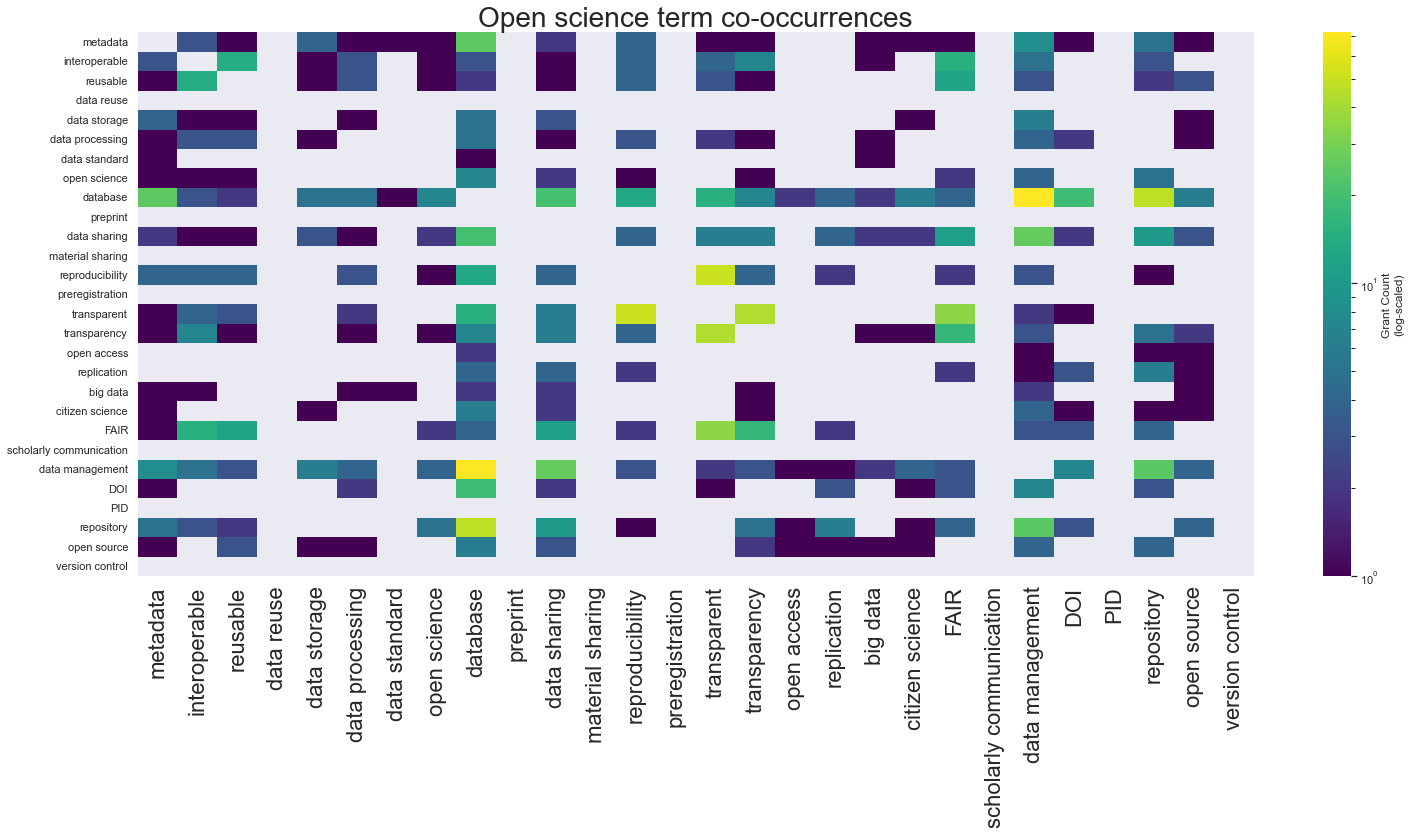

In [ ]:
import numpy as np
import copy
from matplotlib.colors import LogNorm
# ok, lets create a matrix that holds co-occurance data
# let's start by making a blank matrix to hold the data
connectivityMatrix=np.zeros((len(keywords),len(keywords)), dtype=np.int32())
# also make a list to hold the rows from this
dfRowContentAll=[]
# should be symmetric so x and y doesn't really matter
# use this opportunity to get the indexes of the lower triangle though
lowerTriIndices = [list(x) for x in np.tril_indices_from(connectivityMatrix)]
#convert this to the format we need
lowerTriList=[[lowerTriIndices[0][iIndex],lowerTriIndices[1][iIndex]] for iIndex in range(len(lowerTriIndices[0]))]
# iterate across both axes

for iIndexX, iKeywordsX in enumerate(keywords):
    for iIndexY, iKeywordsY in enumerate(keywords):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX.replace(' ','_')]
        IDsY=grantFindsOut[iKeywordsY.replace(' ','_')]
        # find the intersection
        intersectionGrants=list(set(IDsX) & set(IDsY))
        # find the size of that intersection
        sharedGrantNum=len(intersectionGrants)
        connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
        # do components for dataframe

        if not [iIndexX,iIndexY] in lowerTriList:
            print 
            
            if iKeywordsX==iKeywordsY:
                # half it for the visualization for self connections
                #dfRowContent=[iKeywordsX, iKeywordsY, np.divide(sharedGrantNum,2).astype(np.int32)]
                # or set it to zero
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')' , 0]
            else:
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')', sharedGrantNum]
            dfRowContentAll.append(dfRowContent)

flatConMatrix=pd.DataFrame(data=dfRowContentAll, columns=['keyword1','keyword2','value'])

# mask out the diagonal so it doesn't overwhelm the plot
diagonalMask=np.eye(len(keywords),dtype=bool)
# copy the matrix so it can be modified 
plotMatrix=copy.deepcopy(connectivityMatrix)
# set the diagonal to zero
plotMatrix[diagonalMask]=np.zeros(len(keywords))
# replace zero with empty, to clean up plot                

    
sns.heatmap(data=plotMatrix,yticklabels=keywords,xticklabels=keywords,cmap='viridis',norm=LogNorm(),cbar_kws={'label': 'Grant Count\n(log-scaled)'})
plt.gcf().get_axes()[0].set_xticklabels(plt.gcf().get_axes()[0].get_xticklabels(), fontsize=22)
plt.gcf().get_axes()[0].set_title('Open science term co-occurrences',fontsize=28)

#### A different view

The above matrix plot provides a good sense of the quantative characteristics of term co-occurance in the grants.  However, this sort of visualization may not completely encapsulate the overall patterns that we may be looking for.  For an alternate perspective we can try a chord diagram.

NOTE:  The code block below makes use of [d3blocks](https://github.com/d3blocks/d3blocks), which is a python package that is unlikely to be installed by default.  Also note, that this code block will open up a new window with the resulting figure.

In [ ]:
from d3blocks import D3Blocks
import os
# Initialize
d3 = D3Blocks()
# change the column names to what's required by d3blocks
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html
flatConMatrix=flatConMatrix.rename(columns={"keyword1": "source", "keyword2": "target", 'value': 'weight'})
# notebook= True doesn't seem to work
# d3.chord(flatConMatrix,filepath=None,notebook=True)
d3.chord(flatConMatrix, showfig=False,filepath='./d3blocks.html')

import IPython
IPython.display.IFrame('d3blocks.html',height=900,width=1000)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\dbullock\Documents\code\gitDir\USG_grants_crawl\notebooks\d3blocks.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
